In [1]:
import sys
import socket
print("Working node:", socket.gethostname())
sys.path.append('/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/')
from global_variables import *

Working node: bbgn005


In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import math

In [238]:
def get_all_o3d_gene_result(cohort_df, o3d_output_dir):

    lst_df = []
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv)
            lst_df.append(df_o3d)
        else:
            print(f"Path doesn't exist: {path_csv}")

    return pd.concat(lst_df)

datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir)
df_results.Cohort = df_results.Cohort.str.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
df_results = df_results[["Gene", "Uniprot_ID", "Cohort", "pval", "qval"]].dropna(subset=["pval"])
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
df_results.pval = df_results.pval.replace(0, 0.00001)
df_results

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


,Gene,Uniprot_ID,Cohort,pval,qval
0,NFE2L2,Q16236,TCGA_WXS_LUSC,0.00001,0.0
1,TP53,K7PPA8,TCGA_WXS_LUSC,0.00001,0.0
2,PIK3CA,P42336,TCGA_WXS_LUSC,0.00001,0.0
3,CDKN2A,K7PML8,TCGA_WXS_LUSC,0.00001,0.0
4,HRAS,P01112,TCGA_WXS_LUSC,0.00001,0.0
...,...,...,...,...,...
36091,SUSD4,Q5VX71,TCGA_WXS_PGNG,0.06350,1.0
36092,PMM1,A0A024R1U5,TCGA_WXS_PGNG,0.19130,1.0
36093,NAGK,A0A384N6G7,TCGA_WXS_PGNG,0.21440,1.0
36094,ADH6,P28332,TCGA_WXS_PGNG,0.21830,1.0


In [247]:
def qq_plot(df_results, filename):
    
    cols = 4
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 16), constrained_layout=True)
    axes = axes.flatten()
    
    for i, (cohort, df) in enumerate(df_results.groupby("Cohort")):
    
        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Plot observed vs. theoretical p-values
        #ax.scatter(expected, pvals, c=np.where(df["qval"] < 0.01, 'red', 'blue'), alpha=0.6)
        ax.scatter(expected, pvals, alpha=0.6)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')
        
        # Add labels and title for each subplot
        ax.set_title(cohort.split("_")[len(cohort.split("_"))-1])
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.legend()
    
    fig.supxlabel(f"Theoretical quantiles\n-log10(p-values)")
    fig.supylabel(f"Observed quantiles\n  -log10(p-values)")
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

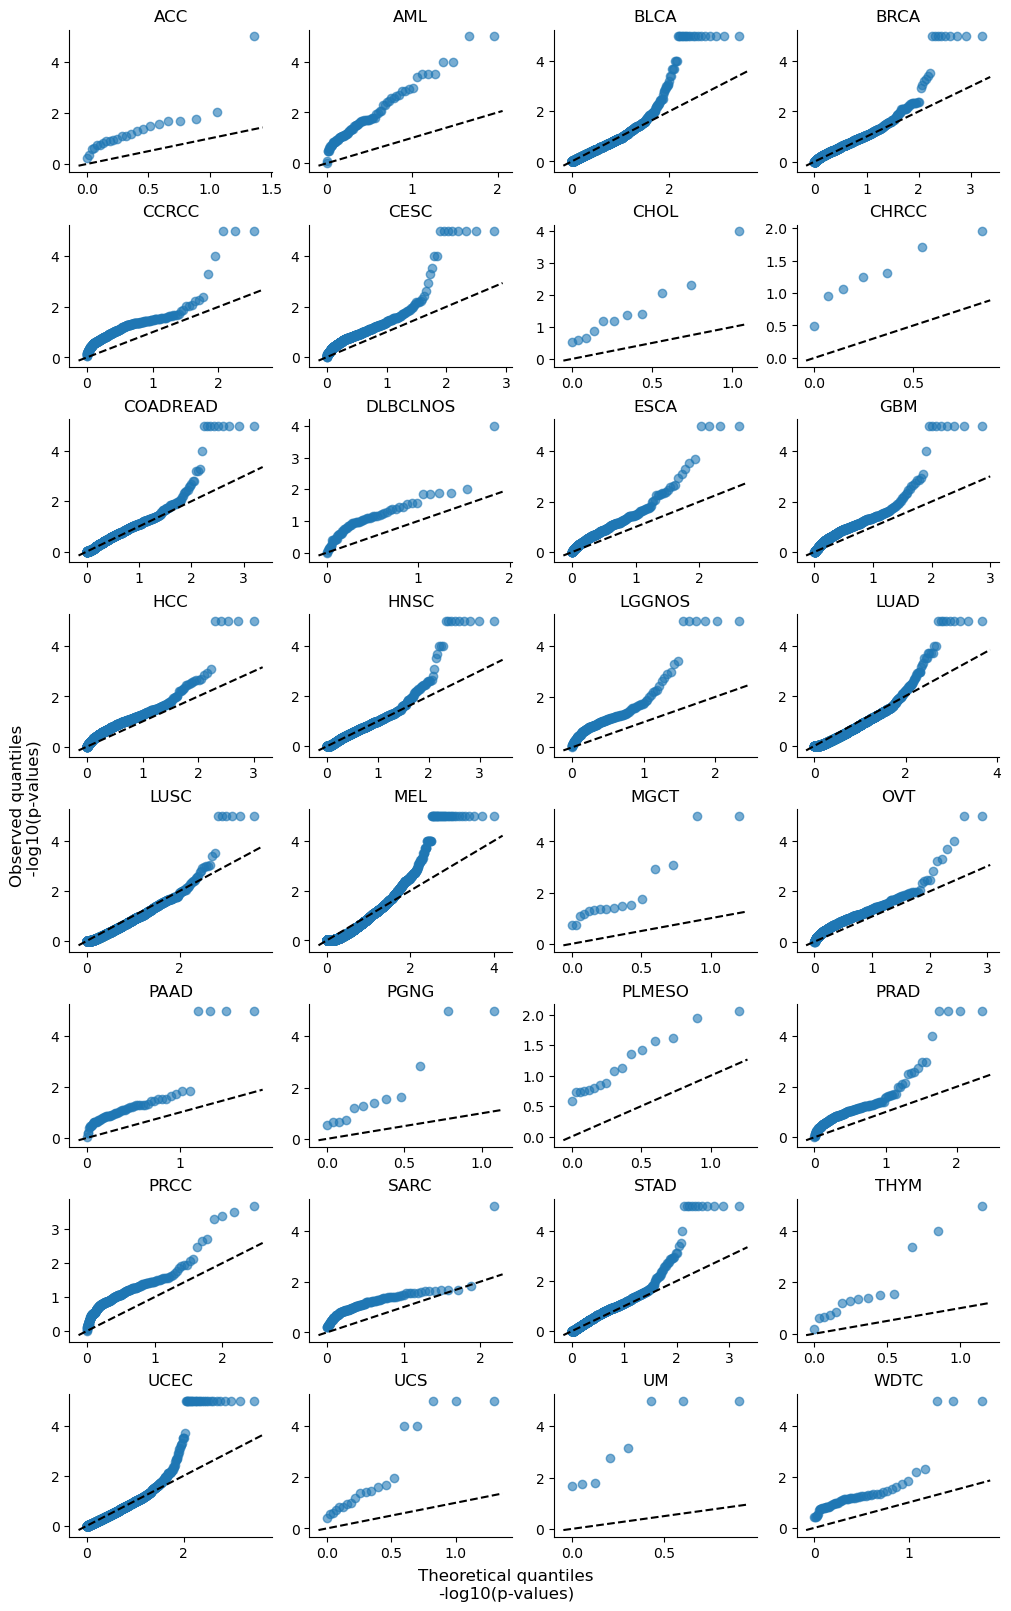

In [248]:
qq_plot(df_results, filename="qq_plot_tcga.png")